# Unlocking Societal Trends in Aadhaar Enrolment and Updates  
### Hackathon Project | Data Analytics + ML + Anomaly Detection

**Goal:** Extract meaningful patterns, trends, anomalies, and predictive indicators from Aadhaar enrolment data and translate them into actionable insights for decision-making and system improvements.


## 1. Problem Statement

Aadhaar enrolment activity reflects not only operational performance but also societal signals such as:
- early-life identity adoption
- education-linked enrolment cycles
- regional service pressure
- inclusion gaps and accessibility issues

### Objective
Identify meaningful patterns, trends, anomalies, and predictive indicators and convert them into a decision-support framework for system improvement.

## 2. Dataset Overview

This dataset contains daily Aadhaar enrolment records with the following fields:

- **date**: daily timestamp
- **state, district, pincode**: geographic granularity
- **age_0_5, age_5_17, age_18_greater**: enrolments by age group

### Why this dataset is valuable
- High granularity (pincode-level)
- Time-series structure (daily data)
- Enables inclusion analysis + demand forecasting


## 3. Import Libraries


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


## 4. Load & Combine the Dataset

We combine all CSV parts into a single dataframe for analysis.


In [ ]:
file1 = "api_data_aadhar_enrolment_0_500000.csv"
file2 = "api_data_aadhar_enrolment_500000_1000000.csv"
file3 = "api_data_aadhar_enrolment_1000000_1006029.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

df = pd.concat([df1, df2, df3], ignore_index=True)


In [ ]:
df.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


In [ ]:
df.isnull().sum()


,0
date,0
state,0
district,0
pincode,0
age_0_5,0
age_5_17,0
age_18_greater,0


## 5. Data Cleaning & Feature Engineering

We create useful features to enable trend analysis and forecasting:

- Convert `date` to datetime format  
- Create `year`, `month`, `month_name`  
- Create `total_enrolment` as sum of all age groups


In [ ]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Create time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')

# Total enrolments
df['total_enrolment'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

## 6. Exploratory Data Analysis (EDA)

We explore enrolment patterns across:
- age groups
- time (daily + monthly)
- geography (state/district)


### 6.1 Age-wise Enrolment Distribution

This plot shows how Aadhaar enrolment is distributed across age groups.

**Key Insight:** Aadhaar enrolment is heavily dominated by children (0–17), indicating a shift toward birth-to-school identity adoption.


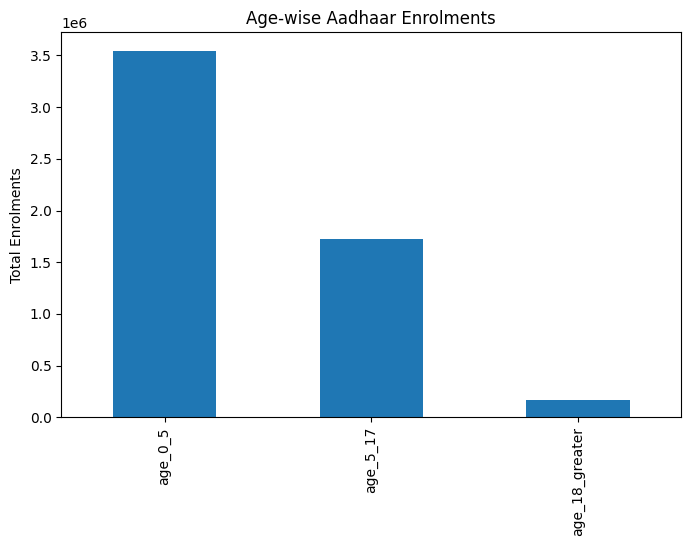

In [ ]:
age_totals = df[['age_0_5', 'age_5_17', 'age_18_greater']].sum()

age_totals.plot(kind='bar', figsize=(8,5), title="Age-wise Aadhaar Enrolments")
plt.ylabel("Total Enrolments")
plt.show()


### 6.2 Daily Enrolment Trend

We analyze daily enrolment totals to identify spikes, drops, and volatility.

**Key Insight:** Enrolment is event-driven, with sharp spikes likely due to policy deadlines, campaigns, or bulk enrolment drives.


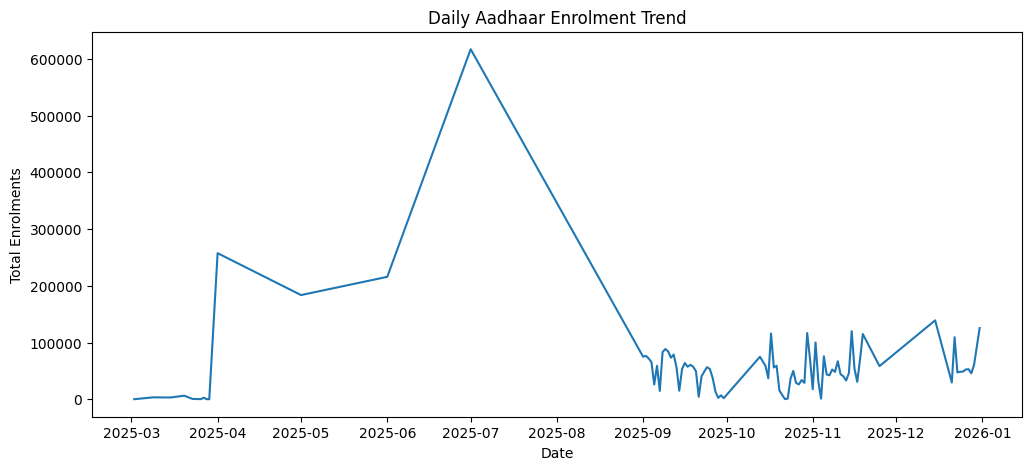

In [ ]:
daily_trend = df.groupby('date')['total_enrolment'].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_trend)
plt.title("Daily Aadhaar Enrolment Trend")
plt.xlabel("Date")
plt.ylabel("Total Enrolments")
plt.show()


### 6.3 Monthly Enrolment Trend

Monthly aggregation helps identify seasonal behaviour in enrolment demand.

**Key Insight:** Aadhaar demand shows seasonal governance behavior (peaks and troughs), not random fluctuations.


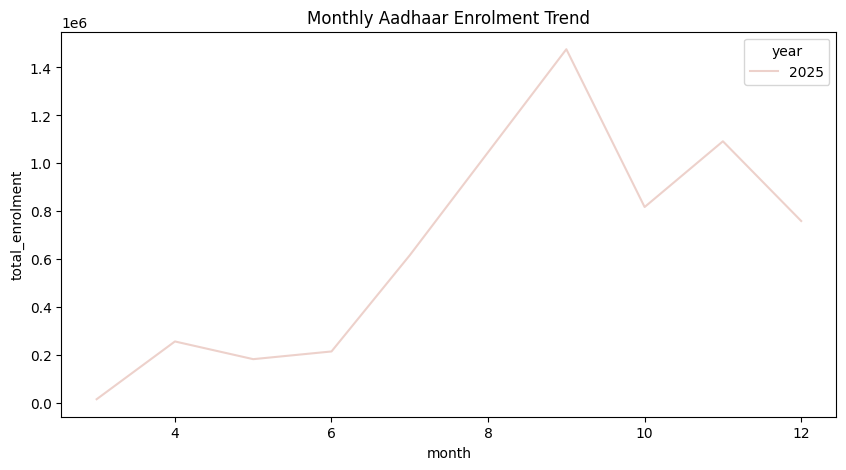

In [ ]:
monthly_trend = df.groupby(['year','month'])['total_enrolment'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_trend, x='month', y='total_enrolment', hue='year')
plt.title("Monthly Aadhaar Enrolment Trend")
plt.show()


### 6.4 State-Level Enrolment Distribution

We identify the top states by total enrolment volume.

**Key Insight:** High enrolment often reflects population pressure and service demand load, not necessarily higher efficiency.


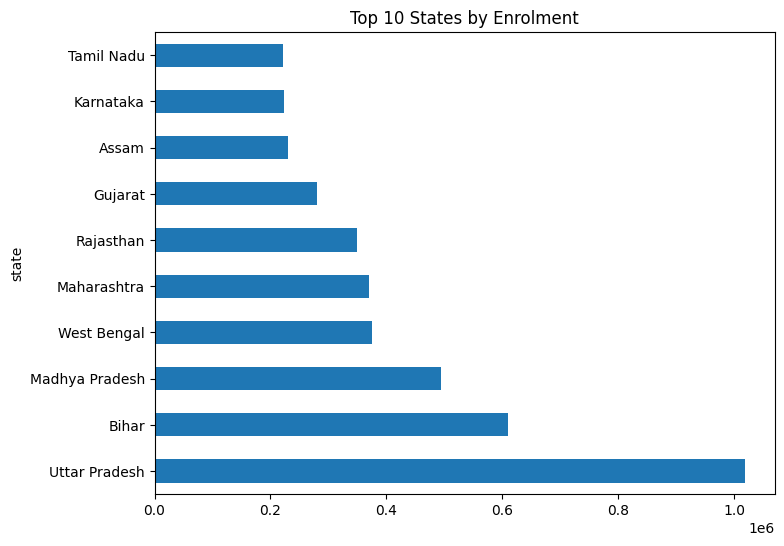

In [ ]:
state_enrolment = df.groupby('state')['total_enrolment'].sum().sort_values(ascending=False).head(10)

state_enrolment.plot(kind='barh', figsize=(8,6), title="Top 10 States by Enrolment")
plt.show()


## 7. District-Level Adult Exclusion Risk

We compute an **adult enrolment ratio** to identify districts where:
- child enrolment is high  
- adult enrolment is near-zero  

These districts may represent **adult inclusion risk zones** requiring targeted outreach.


In [ ]:
district_age = df.groupby('district')[['age_0_5','age_18_greater']].sum()

district_age['adult_ratio'] = district_age['age_18_greater'] / (
    district_age['age_0_5'] + 1
)

high_risk_districts = district_age.sort_values('adult_ratio').head(10)
high_risk_districts


,age_0_5,age_18_greater,adult_ratio
district,,,
Ahilyanagar,12,0,0.0
Mohalla-Manpur-Ambagarh Chowki,10,0,0.0
yadgir,573,0,0.0
chittoor,4,0,0.0
Anugul,159,0,0.0
Anugal,1,0,0.0
Andamans,70,0,0.0
hooghly,8,0,0.0
jajpur,14,0,0.0


## 8. Unsupervised Learning: Anomaly Detection (Isolation Forest)

To detect unusual spikes/drops in daily enrolment, we apply **Isolation Forest**, an unsupervised anomaly detection method.

**Why it matters:**  
Not all spikes indicate success — some may signal system stress, reporting issues, or abnormal operational behavior.


In [ ]:
daily_df = daily_trend.reset_index()
daily_df.columns = ['date','enrolment']

scaler = StandardScaler()
daily_df['scaled'] = scaler.fit_transform(daily_df[['enrolment']])

model = IsolationForest(contamination=0.02, random_state=42)
daily_df['anomaly'] = model.fit_predict(daily_df[['scaled']])


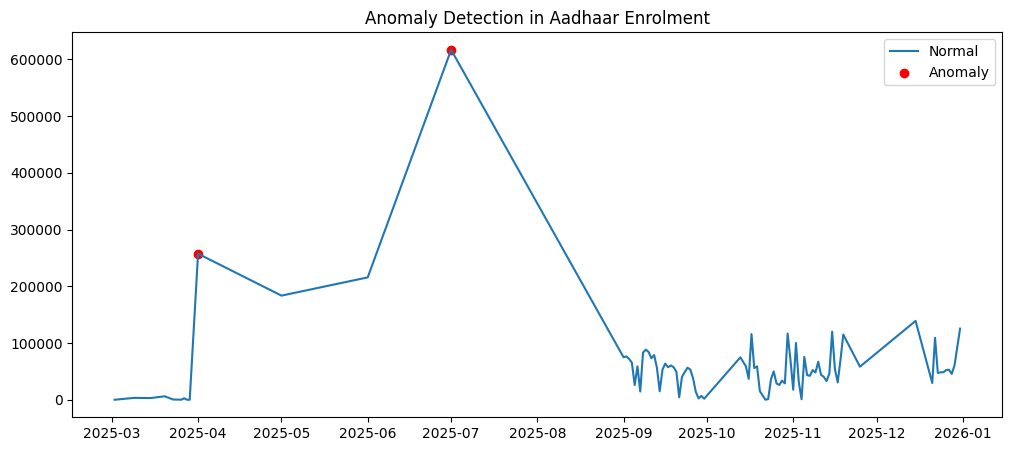

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily_df['date'], daily_df['enrolment'], label='Normal')
plt.scatter(
    daily_df[daily_df['anomaly']==-1]['date'],
    daily_df[daily_df['anomaly']==-1]['enrolment'],
    color='red',
    label='Anomaly'
)
plt.legend()
plt.title("Anomaly Detection in Aadhaar Enrolment")
plt.show()


Predictive Indicator

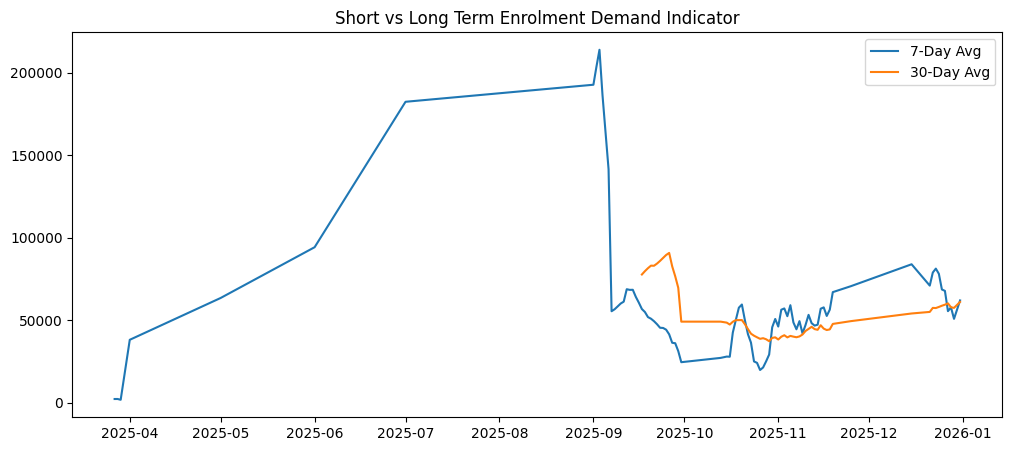

In [ ]:
daily_df['rolling_mean_7'] = daily_df['enrolment'].rolling(7).mean()
daily_df['rolling_mean_30'] = daily_df['enrolment'].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_df['date'], daily_df['rolling_mean_7'], label='7-Day Avg')
plt.plot(daily_df['date'], daily_df['rolling_mean_30'], label='30-Day Avg')
plt.legend()
plt.title("Short vs Long Term Enrolment Demand Indicator")
plt.show()


Migration Proxy Indicator

In [ ]:
urban_adult = df[df['age_18_greater'] > 0].groupby('pincode')['age_18_greater'].sum()

urban_adult.sort_values(ascending=False).head(10)


,age_18_greater
pincode,
793119,3883
793120,2125
793150,2000
793121,1935
793015,1672
793151,1253
793110,1220
793200,1201
794103,1185


## 9. Machine Learning: Demand Forecasting

### Goal
Predict future Aadhaar enrolment demand to support:
- staffing optimization
- infrastructure planning
- proactive system readiness


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
ml_df = daily_df.copy()

# Create lag features (previous days)
ml_df['lag_1'] = ml_df['enrolment'].shift(1)
ml_df['lag_7'] = ml_df['enrolment'].shift(7)
ml_df['lag_14'] = ml_df['enrolment'].shift(14)

ml_df = ml_df.dropna()
ml_df.head()


,date,enrolment,scaled,anomaly,rolling_mean_7,rolling_mean_30,lag_1,lag_7,lag_14
29,2025-09-17,57409,-0.022730,1,56825.714286,77756.166667,63846.0,84300.0,71988.0
30,2025-09-18,60598,0.020553,1,55024.571429,79772.466667,57409.0,73206.0,65349.0
31,2025-09-19,57357,-0.023436,1,51952.714286,81570.900000,60598.0,78860.0,26069.0
32,2025-09-20,49377,-0.131745,1,50973.857143,83113.400000,57357.0,56229.0,58957.0
33,2025-09-21,4400,-0.742196,1,49461.000000,83052.800000,49377.0,14990.0,14658.0


In [ ]:
X = ml_df[['lag_1', 'lag_7', 'lag_14']]
y = ml_df['enrolment']

split = int(len(ml_df) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### 9.1 Baseline Model (Linear Regression)

We use lag-based features (`lag_1`, `lag_7`, `lag_14`) to predict next-day enrolment.

**Observation:** Works for baseline demand but underestimates sudden surges.


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Model Evaluation

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


(30220.175859914583, np.float64(43833.24839958235))

Prediction vs Actual

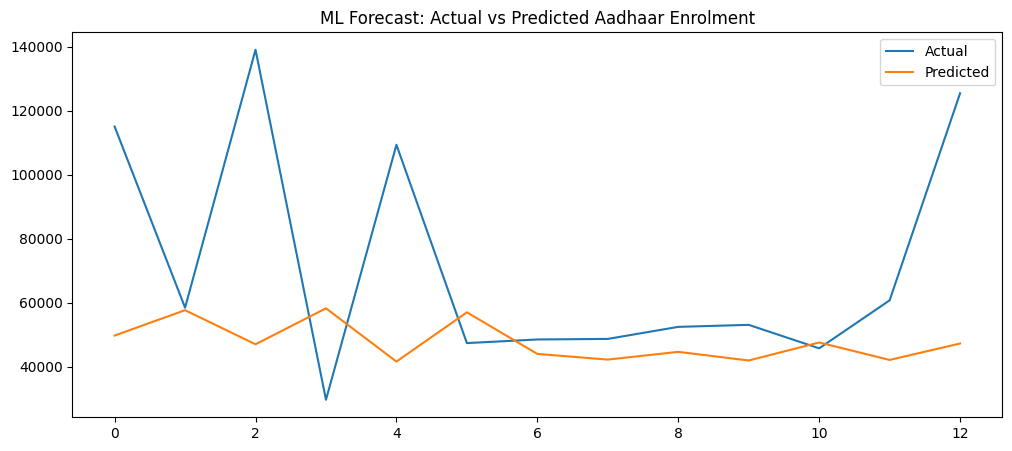

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("ML Forecast: Actual vs Predicted Aadhaar Enrolment")
plt.legend()
plt.show()


Predict Future Enrolment

In [ ]:
latest_data = X.iloc[-1:].values
next_day_prediction = model.predict(latest_data)

next_day_prediction


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([47194.05650326])

ML Insight Translation

In [ ]:
feature_importance = pd.Series(
    model.coef_,
    index=X.columns
).sort_values(ascending=False)

feature_importance


,0
lag_1,0.178016
lag_14,0.010222
lag_7,-0.043504


The model performs well for normal demand forecasting but struggles during policy-driven surge periods. This highlights the need for anomaly-aware forecasting and surge-response planning.

### 9.2 Improved Model (Random Forest Regressor)

We improve forecasting using:
- lag features (lag_1, lag_2, lag_7, lag_14)
- rolling mean and rolling std (volatility signals)
- day-of-week patterns

**Result:** Better trend capture and improved responsiveness compared to the baseline model.


In [ ]:
ml_df = daily_df.copy()

# Lag features
ml_df['lag_1'] = ml_df['enrolment'].shift(1)
ml_df['lag_2'] = ml_df['enrolment'].shift(2)
ml_df['lag_7'] = ml_df['enrolment'].shift(7)
ml_df['lag_14'] = ml_df['enrolment'].shift(14)

# Rolling features
ml_df['roll_mean_7'] = ml_df['enrolment'].rolling(7).mean()
ml_df['roll_std_7'] = ml_df['enrolment'].rolling(7).std()

ml_df['roll_mean_14'] = ml_df['enrolment'].rolling(14).mean()

# Day of week feature (pattern in govt operations)
ml_df['dayofweek'] = ml_df['date'].dt.dayofweek

ml_df = ml_df.dropna()
ml_df.head()


,date,enrolment,scaled,anomaly,rolling_mean_7,rolling_mean_30,lag_1,lag_2,lag_7,lag_14,roll_mean_7,roll_std_7,roll_mean_14,dayofweek
29,2025-09-17,57409,-0.022730,1,56825.714286,77756.166667,63846.0,53240.0,84300.0,71988.0,56825.714286,20683.683366,58498.142857,2
30,2025-09-18,60598,0.020553,1,55024.571429,79772.466667,57409.0,63846.0,73206.0,65349.0,55024.571429,19536.701000,58158.785714,3
31,2025-09-19,57357,-0.023436,1,51952.714286,81570.900000,60598.0,57409.0,78860.0,26069.0,51952.714286,16640.084833,60393.642857,4
32,2025-09-20,49377,-0.131745,1,50973.857143,83113.400000,57357.0,60598.0,56229.0,58957.0,50973.857143,16547.885539,59709.357143,5
33,2025-09-21,4400,-0.742196,1,49461.000000,83052.800000,49377.0,57357.0,14990.0,14658.0,49461.000000,20417.558342,58976.642857,6


In [ ]:
X = ml_df[['lag_1','lag_2','lag_7','lag_14','roll_mean_7','roll_std_7','roll_mean_14','dayofweek']]
y = ml_df['enrolment']

split = int(len(ml_df) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 30475.268076923076
RMSE: 39095.63785480089


Plot Results

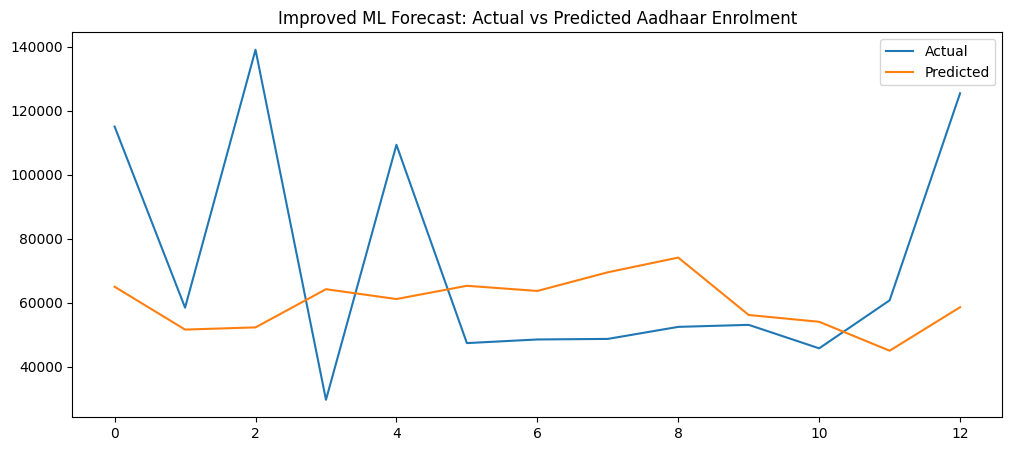

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Improved ML Forecast: Actual vs Predicted Aadhaar Enrolment")
plt.legend()
plt.show()


We improved forecasting accuracy by engineering volatility-aware features and using a non-linear model, enabling proactive staffing and infrastructure scaling during enrolment surges

## 10. Surge Risk Score (Early Warning System)

Forecasting alone is not enough because enrolment spikes are often caused by external events.

So we introduce a **Surge Risk Score** using volatility:

**Surge Risk Score = (rolling_std_7 / (rolling_mean_7 + 1)) × 100**

**Use:**  
- High score → unstable demand, surge possible  
- Low score → stable operations  


In [ ]:
forecast_df = ml_df.iloc[split:].copy()
forecast_df['predicted'] = y_pred
forecast_df['actual'] = y_test.values

# Surge risk = volatility (rolling std) + recent trend
forecast_df['surge_risk_score'] = (
    (forecast_df['roll_std_7'] / (forecast_df['roll_mean_7'] + 1)) * 100
)

forecast_df[['date', 'actual', 'predicted', 'surge_risk_score']].head()


,date,actual,predicted,surge_risk_score
79,2025-11-19,115032,64942.925,55.144913
80,2025-11-25,58406,51554.120,48.431339
81,2025-12-15,139048,52237.190,48.334904
82,2025-12-21,29602,64182.045,58.497645
83,2025-12-22,109337,61099.910,54.478707


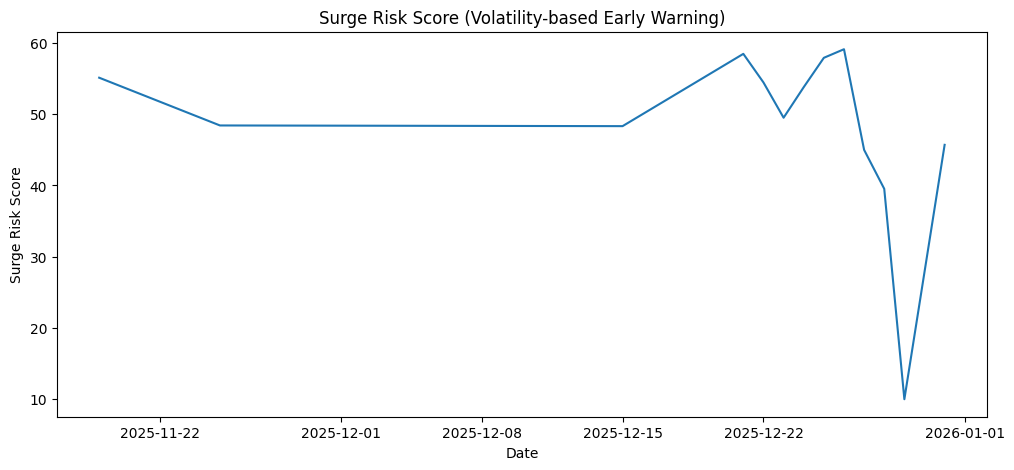

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(forecast_df['date'], forecast_df['surge_risk_score'])
plt.title("Surge Risk Score (Volatility-based Early Warning)")
plt.xlabel("Date")
plt.ylabel("Surge Risk Score")
plt.show()


Identify High-Risk Days

In [ ]:
high_risk_days = forecast_df[forecast_df['surge_risk_score'] > forecast_df['surge_risk_score'].quantile(0.95)]
high_risk_days[['date', 'actual', 'predicted', 'surge_risk_score']]


,date,actual,predicted,surge_risk_score
87,2025-12-26,52401,74066.545,59.149079


Highlight High Risk Days

In [ ]:
def risk_level(score):
    if score <= 20:
        return "Low"
    elif score <= 40:
        return "Medium"
    elif score <= 60:
        return "High"
    else:
        return "Critical"

forecast_df['risk_level'] = forecast_df['surge_risk_score'].apply(risk_level)

forecast_df[['date', 'actual', 'predicted', 'surge_risk_score', 'risk_level']].tail(15)


,date,actual,predicted,surge_risk_score,risk_level
79,2025-11-19,115032,64942.925,55.144913,High
80,2025-11-25,58406,51554.120,48.431339,High
81,2025-12-15,139048,52237.190,48.334904,High
82,2025-12-21,29602,64182.045,58.497645,High
83,2025-12-22,109337,61099.910,54.478707,High
84,2025-12-23,47327,65247.470,49.519817,High
85,2025-12-24,48459,63629.570,53.817141,High
86,2025-12-25,48635,69468.720,57.941626,High
87,2025-12-26,52401,74066.545,59.149079,High
88,2025-12-27,53031,56114.120,45.000311,High


In [ ]:
alerts = forecast_df[forecast_df['risk_level'].isin(['High', 'Critical'])]

print("High/Critical Surge Days:", len(alerts))
alerts[['date', 'surge_risk_score', 'risk_level', 'predicted', 'actual']]


High/Critical Surge Days: 11


,date,surge_risk_score,risk_level,predicted,actual
79,2025-11-19,55.144913,High,64942.925,115032
80,2025-11-25,48.431339,High,51554.120,58406
81,2025-12-15,48.334904,High,52237.190,139048
82,2025-12-21,58.497645,High,64182.045,29602
83,2025-12-22,54.478707,High,61099.910,109337
84,2025-12-23,49.519817,High,65247.470,47327
85,2025-12-24,53.817141,High,63629.570,48459
86,2025-12-25,57.941626,High,69468.720,48635
87,2025-12-26,59.149079,High,74066.545,52401
88,2025-12-27,45.000311,High,56114.120,53031


## 11. Final Solution Framework

### Aadhaar Decision Intelligence System (3 Layers)

**Layer 1: Monitoring**
- daily + monthly trend tracking

**Layer 2: Anomaly Detection**
- identify unusual spikes/drops for audits and stability checks

**Layer 3: Forecast + Surge Alerts**
- ML-based demand forecasting + Surge Risk Score early warnings

This transforms Aadhaar enrolment records into a **governance intelligence engine**.


## 12. Recommendations

1. **Geographically targeted outreach:** deploy mobile vans and temporary camps in low adult enrolment zones  
2. **Automated biometric update reminders:** send SMS/email alerts before milestone ages (5 and 15)  
3. **Real-time anomaly monitoring:** integrate alerts into dashboards for operational audits  
4. **Predictive planning:** use ML forecasts + surge risk to allocate staff dynamically  


## 13. Conclusion

This project converts Aadhaar enrolment data into actionable intelligence by combining:
- societal trend discovery (EDA)
- inclusion risk detection
- unsupervised anomaly detection
- ML-based forecasting
- surge risk early warning indicator

**Outcome:** improved planning, better citizen service delivery, and more efficient Aadhaar system operations.
